# This notebook is based on the exercise "California Housing Prices" in chapter 2 of the brilliant book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" from A. Géron.

The dataset was downloaded from: <br>
https://github.com/ageron/handson-ml/tree/master/datasets/housing <br>
The webpage also contains information about the dataset.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
print('Python version info: ' + str(sys.version_info))

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
print('Scikit-Learn version: ' + sklearn.__version__ + '\n')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

pd.options.display.float_format = '{:.2f}'.format

print('Matplotlib version: ' + matplotlib.__version__)
print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print()

Python version info: sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
Scikit-Learn version: 0.22.1

Matplotlib version: 3.1.1
Numpy version: 1.18.1
Pandas version: 1.0.3



## Download the dataset

In [2]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df_housing_raw = pd.read_csv(url)

### Get a first impression of the dataset by using the methods ".head()", ".info()" and ".describe()"

In [3]:
df_housing_raw.head(6)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY
5,-122.25,37.85,52.00,919.00,213.00,413.00,193.00,4.04,269700.00,NEAR BAY


The dataset contains 1 categorical column and 9 numerical columns.

In [4]:
df_housing_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.7 MB


The column (feature) "total_bedrooms" doesn't have as many non-null elements as all the other columns.

In [5]:
df_housing_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


### Get a first graphical impression of the numerical columns ...

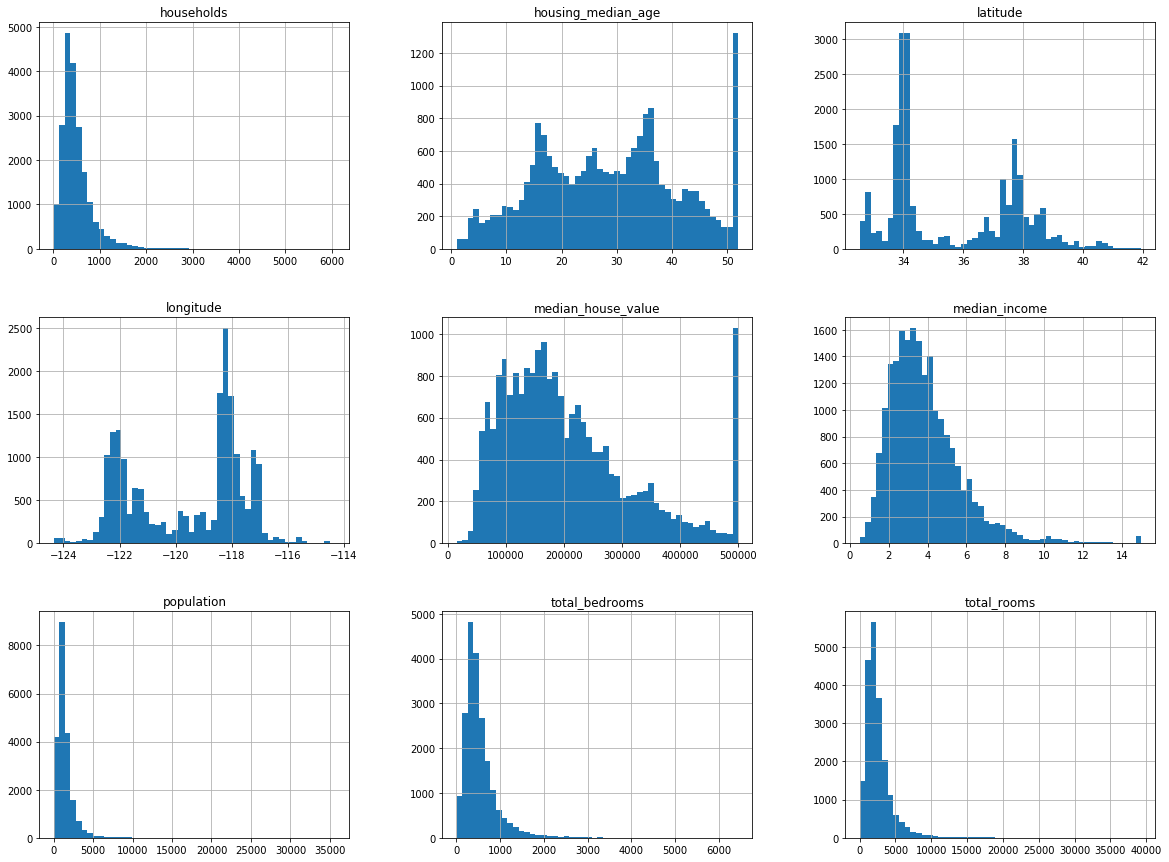

In [6]:
%matplotlib inline
df_housing_raw.hist(bins=50, figsize=(20,15));

The histograms of the values in the columns "median_house_age" and "median_house_value" look like they are cut off at their max-values. Latitude and Longitude are numerical values but with no "meaningful scale".

### ... and get a first impression of the column containing categories (Number of occurances of each category)

In [7]:
df_housing_raw['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<br>

# Baseline Model

The easiest but probably not the most accurate way to predict the "median_house_value" is to take the mean (or the median) of the "median_house_values" contained in the training data. Let's see how the error metrics look. These values should be improved by using more sophisticated models later on.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_housing_raw,
                                                    df_housing_raw['median_house_value'],
                                                    test_size=0.2, random_state=2)

"df_housing_raw" is not entirely the correct parameter in this case, but it doesn't matter, because the feature columns won't be used (in this case).

In [9]:
mean_median_house_value = y_train.mean()
median_median_house_value = y_train.median()

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

mean_prediction = pd.Series([mean_median_house_value]).repeat(len(y_test))
median_prediction = pd.Series([median_median_house_value]).repeat(len(y_test))

r2_base_mean = r2_score(y_test, mean_prediction)
r2_base_median = r2_score(y_test, median_prediction)
rmse_base_mean = np.sqrt(mean_squared_error(y_test, mean_prediction))
rmse_base_median = np.sqrt(mean_squared_error(y_test, median_prediction))
mae_base_mean = mean_absolute_error(y_test, mean_prediction)
mae_base_median = mean_absolute_error(y_test, median_prediction)

df_error_metrics = pd.DataFrame({'R-Squared': [r2_base_mean, r2_base_median],
                                 'RMSE': [rmse_base_mean, rmse_base_median],
                                 'MAE': [mae_base_mean, mae_base_median],
                                 'CrossVal RMSE': [np.nan, np.nan],
                                 'CrossVal Stddev': [np.nan, np.nan]},
                                index=['Mean', 'Median'])
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan


<br>

# Data exploration

Convert the values of the columns "longitude" and "latitude" to geographical points:

In [11]:
import geopandas
from shapely.geometry import Point

gdf_housing_raw = geopandas.GeoDataFrame(df_housing_raw,
                                         geometry=geopandas.points_from_xy(df_housing_raw['longitude'], df_housing_raw['latitude']))

Load the California county borders (from: https://data.ca.gov/dataset/ca-geographic-boundaries)

In [12]:
cal_counties = geopandas.read_file("CA_Counties/CA_Counties_TIGER2016.shp")
cal_counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."


The columns "NAMELSAD" and "geometry" are important, so I only keep those.

In [13]:
cal_counties = cal_counties[['NAMELSAD', 'geometry']]

The coordinate reference system (crs) of the Points (gdf_housing_raw) doesn't match the crs of the Polygons (cal_counties), so I have to adapt the crs.

In [14]:
cal_counties = cal_counties.to_crs({'init': 'epsg:4326'})

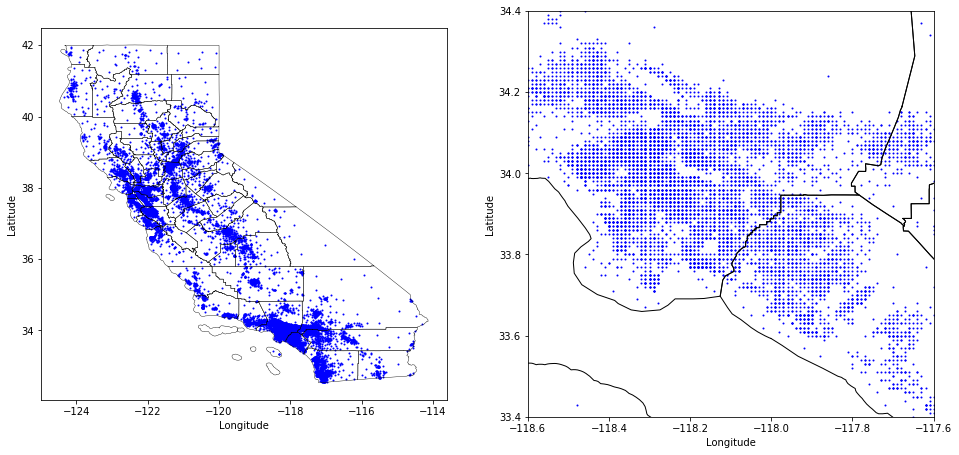

In [15]:
# Plot the datapoints together with the California county borders

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gdf_housing_raw.plot(markersize=1, color='blue', ax=ax1)
cal_counties.plot(facecolor="none", edgecolor='k', lw=0.4, ax=ax1)
gdf_housing_raw.plot(markersize=1, color='blue', ax=ax2)
cal_counties.plot(facecolor="none", edgecolor='k', ax=ax2)
ax2.set_xlim(-118.6, -117.6)  # Zoom to Los Angeles
ax2.set_ylim(33.4, 34.4)
ax1.set_xlabel('Longitude'), ax2.set_xlabel(ax1.get_xlabel())
ax1.set_ylabel('Latitude'), ax2.set_ylabel(ax1.get_ylabel());

As was mentioned above, the values of the columns "latitude" and "longitude" are not of meaningful scale, so I decided to find out which county they belong to and use that as a feature for training later on.

In [16]:
gdf_housing_raw = geopandas.sjoin(gdf_housing_raw, cal_counties, how="inner", op='intersects')
gdf_housing_raw.head(3)

/Users/dirkschulz/anaconda3/envs/portfolio/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,NAMELSAD
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,POINT (-122.23000 37.88000),41,Alameda County
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,POINT (-122.22000 37.86000),41,Alameda County
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY,POINT (-122.24000 37.85000),41,Alameda County


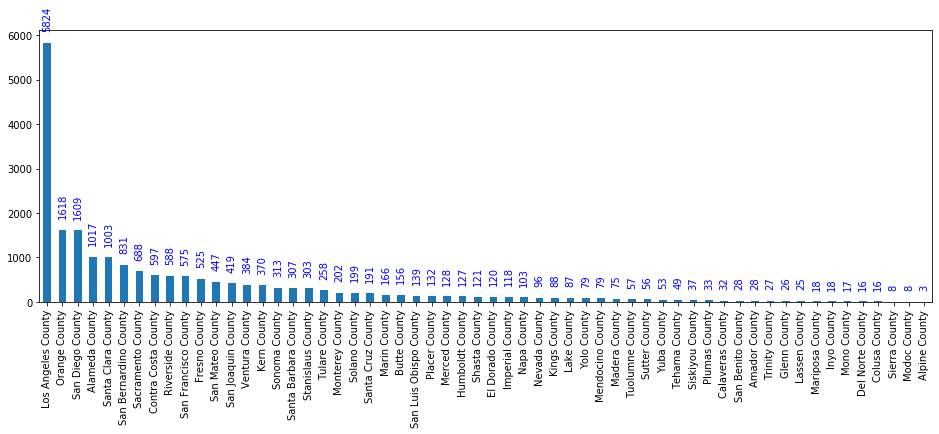

In [17]:
ax = gdf_housing_raw['NAMELSAD'].value_counts().plot(kind='bar', figsize=(16, 5))
for i, v in enumerate(gdf_housing_raw['NAMELSAD'].value_counts()):
    ax.text(i, v + 300, str(v), color='blue', rotation=90, ha='center', fontsize=10);

By far the most datapoints are located in Los Angeles County. This is not optimal for using the location (the County) as a feature. A more evenly distribution would have been better.

In [18]:
corr_matrix = gdf_housing_raw.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.00
median_income         0.69
total_rooms           0.13
housing_median_age    0.11
households            0.07
total_bedrooms        0.05
population           -0.02
longitude            -0.05
index_right          -0.09
latitude             -0.14
Name: median_house_value, dtype: float64

Except the "median_income" there is at best a very weak correlation between the features and the target.

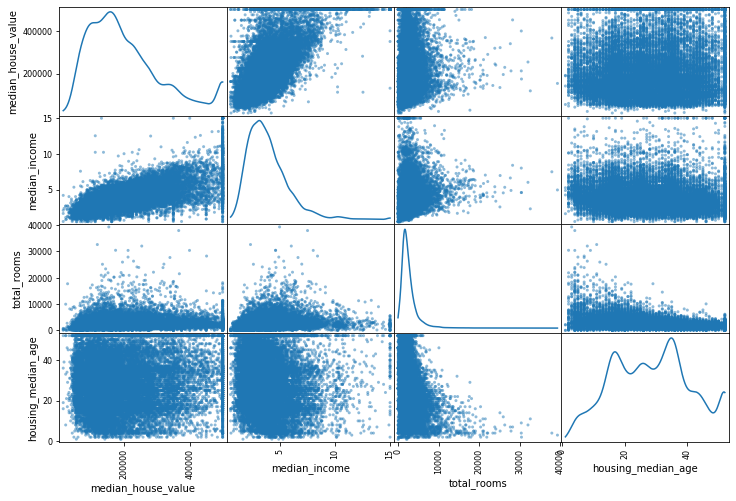

In [19]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(gdf_housing_raw[attributes], diagonal='kde', figsize=(12, 8));

<br>

# First simple Linear Regression model

In [20]:
df_housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  geometry            20640 non-null  geometry
dtypes: float64(9), geometry(1), object(1)
memory usage: 1.7+ MB


In [21]:
# Split in 80% Training data, 10% Validation data and 10% Test data
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw['median_income'],
                                                    df_housing_raw['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_1feature = LinearRegression()
lin_reg_simple_1feature.fit(pd.DataFrame(X_train), y_train)
lin_reg_simple_1feature_predictions_train = lin_reg_simple_1feature.predict(pd.DataFrame(X_train))
lin_reg_simple_1feature_predictions_val = lin_reg_simple_1feature.predict(pd.DataFrame(X_val))

Evaluation of the model performance:

In [22]:
def calc_error_metrics(model, X_train, y_train, y_val, predictions_train, predictions_val):
    print(f'R-Squared Training Set:   {r2_score(y_train, predictions_train):.3f}' +
          f'\nR-Squared Validation Set: {r2_score(y_val, predictions_val):.3f}')
    print(f'RMSE Training Set:   {np.sqrt(mean_squared_error(y_train, predictions_train)):.1f}' +
          f'\nRMSE Validation Set: {np.sqrt(mean_squared_error(y_val, predictions_val)):.1f}')
    print(f'MAE Training Set:   {mean_absolute_error(y_train, predictions_train):.1f}' +
          f'\nMAE Validation Set: {mean_absolute_error(y_val, predictions_val):.1f}\n')
    
    score = np.sqrt(-1 * cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
    print('k-fold CROSS Validation:')
    print('Scores: ', score)
    print('Mean Score: ', score.mean())
    print('Standard dev.: ', score.std())
    return [r2_score(y_val, predictions_val),
            np.sqrt(mean_squared_error(y_val, predictions_val)),
            mean_absolute_error(y_val, predictions_val),
            score.mean(),
            score.std()]

In [23]:
lin_reg_simple_1feature_metrics = calc_error_metrics(lin_reg_simple_1feature, pd.DataFrame(X_train),
                                                   y_train, y_val, 
                                                   lin_reg_simple_1feature_predictions_train,
                                                   lin_reg_simple_1feature_predictions_val)

R-Squared Training Set:   0.476
R-Squared Validation Set: 0.476
RMSE Training Set:   83436.5
RMSE Validation Set: 84707.2
MAE Training Set:   62388.2
MAE Validation Set: 63413.0

k-fold CROSS Validation:
Scores:  [84107.40997757 83879.4982757  84104.61310474 82423.18728685
 82701.64855703]
Mean Score:  83443.27144037842
Standard dev.:  729.2904533655044


In [24]:
def scatter_true_vs_predicted(train_labels, train_predictions, val_labels, val_predictions):
    plt.rcParams.update({'axes.labelsize': 16})
    f, ax1 = plt.subplots(figsize=(8, 8))
    ax1.scatter(train_labels, train_predictions, s=2, alpha=0.3, label='Training Set')
    ax1.scatter(val_labels, val_predictions, s=2, alpha=0.3, label='Validation Set', color='red')
    ax1.plot([0, 500000], [0, 500000], color='black')
    ax1.axis('equal')
    ax1.set_title('True vs. Predicted')
    ax1.set_xlabel('True \"median_house_value\"')
    ax1.set_ylabel('Predicted \"median_house_value\"')
    ax1.text(0.03, 0.87, f'Number of data points:', transform=ax1.transAxes)
    ax1.text(0.03, 0.84, f'Training: {len(train_labels)}', transform=ax1.transAxes)
    ax1.text(0.03, 0.81, f'Validation: {len(val_labels)}', transform=ax1.transAxes)
    ax1.legend();

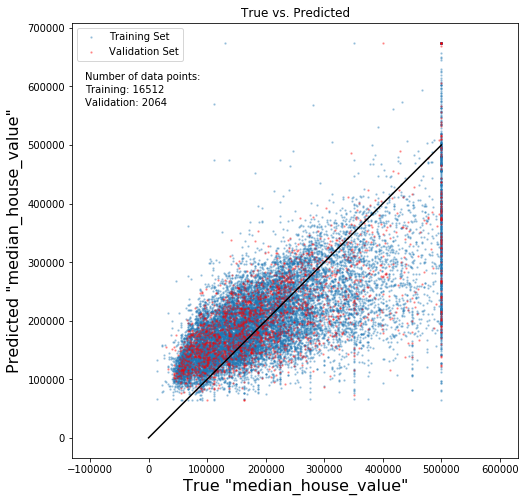

In [25]:
scatter_true_vs_predicted(y_train, lin_reg_simple_1feature_predictions_train,
                          y_val, lin_reg_simple_1feature_predictions_val)

In [26]:
import seaborn as sns

def plot_distribution(train_labels, train_predictions, val_labels, val_predictions):
    f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    sns.distplot(train_labels.values, hist=False, color="b", label='True', ax=ax[0])
    sns.distplot(train_predictions, hist=False, color="r", label='Predictions', ax=ax[0])
    sns.distplot(val_labels.values, hist=False, color="b", label='True', ax=ax[1])
    sns.distplot(val_predictions, hist=False, color="r", label='Predictions', ax=ax[1])
    ax[0].set_title('Relative distribution plot of Predicted and True Training Data')
    ax[1].set_title('Relative distribution plot of Predicted and True Validation Data')
    ax[0].set_xlabel('median_house_price'); ax[1].set_xlabel(ax[0].get_xlabel())
    ax[0].set_ylabel('Relative frequency');

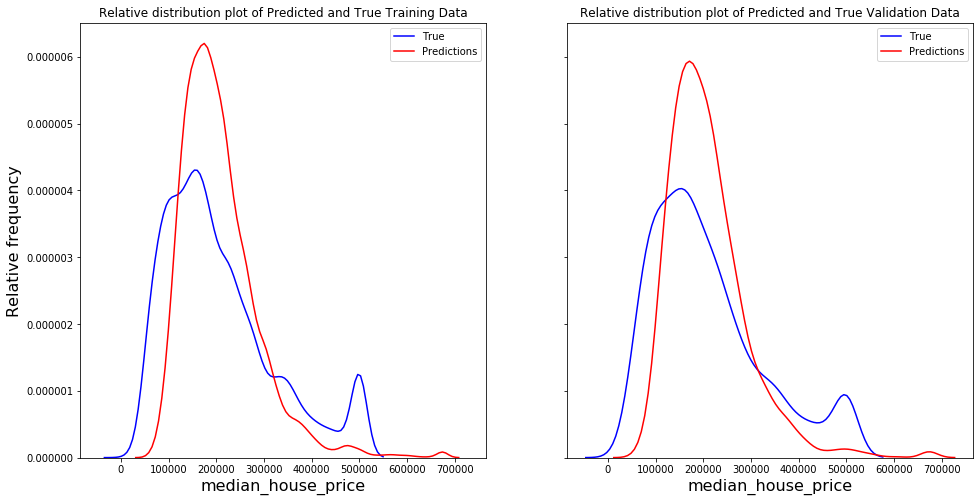

In [27]:
plot_distribution(y_train, lin_reg_simple_1feature_predictions_train,
                  y_val, lin_reg_simple_1feature_predictions_val)

In [28]:
df_error_metrics.loc['LinReg Model 1 feature'] = lin_reg_simple_1feature_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29


The first simple linear regression model delivered an expected improvement compared to the baseline model.

### What if I had taken all numerical features?

In [29]:
features_numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']
df_housing_raw_temp = df_housing_raw.dropna()
df_housing_raw_temp = df_housing_raw_temp.reset_index()

X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp[features_numerical],
                                                    df_housing_raw_temp['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_allfeatures = LinearRegression()
lin_reg_simple_allfeatures.fit(pd.DataFrame(X_train), y_train)
lin_reg_simple_allfeatures_predictions_train = lin_reg_simple_allfeatures.predict(X_train)
lin_reg_simple_allfeatures_predictions_val = lin_reg_simple_allfeatures.predict(X_val)

In [30]:
lin_reg_simple_allfeatures_metrics = calc_error_metrics(lin_reg_simple_allfeatures, X_train,
                                                        y_train, y_val, 
                                                        lin_reg_simple_allfeatures_predictions_train,
                                                        lin_reg_simple_allfeatures_predictions_val)

R-Squared Training Set:   0.639
R-Squared Validation Set: 0.636
RMSE Training Set:   69651.3
RMSE Validation Set: 67762.7
MAE Training Set:   50830.6
MAE Validation Set: 49568.0

k-fold CROSS Validation:
Scores:  [70576.66789925 68236.60794718 70753.78553418 70592.78887263
 68747.83398449]
Mean Score:  69781.53684754715
Standard dev.:  1066.8624712244634


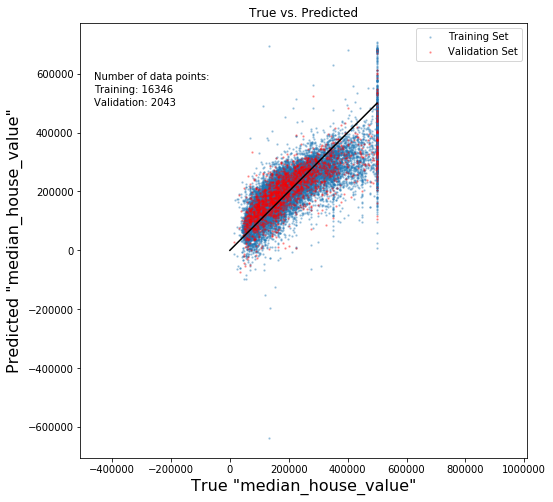

In [31]:
scatter_true_vs_predicted(y_train, lin_reg_simple_allfeatures_predictions_train,
                          y_val, lin_reg_simple_allfeatures_predictions_val)

There are a couple of "median_house_values" that are predicted negative. One value sticks out:

In [32]:
np.where(lin_reg_simple_allfeatures_predictions_train < -500000)

(array([389]),)

In [33]:
lin_reg_simple_allfeatures_predictions_train[389]

-637041.592861799

In [34]:
y_train.iloc[389]

134400.0

In [35]:
X_train.iloc[389, :]

longitude             -117.42
latitude                33.35
housing_median_age      14.00
total_rooms          25135.00
total_bedrooms        4819.00
population           35682.00
households            4769.00
median_income            2.57
Name: 15212, dtype: float64

The "median_income" is 2.57 which is an average median income (see histogramm further up). <br>
The "households" is 4769 which is extreme!!! <br>
The "population" is 35682 and this is extreme as well! <br>
The "total_bedrooms" is 4819 and is extreme! <br>
The "total_rooms" 25135 and is extreme! <br>
So all these extreme numbers might be an explanation why the result of the prediction is far off.

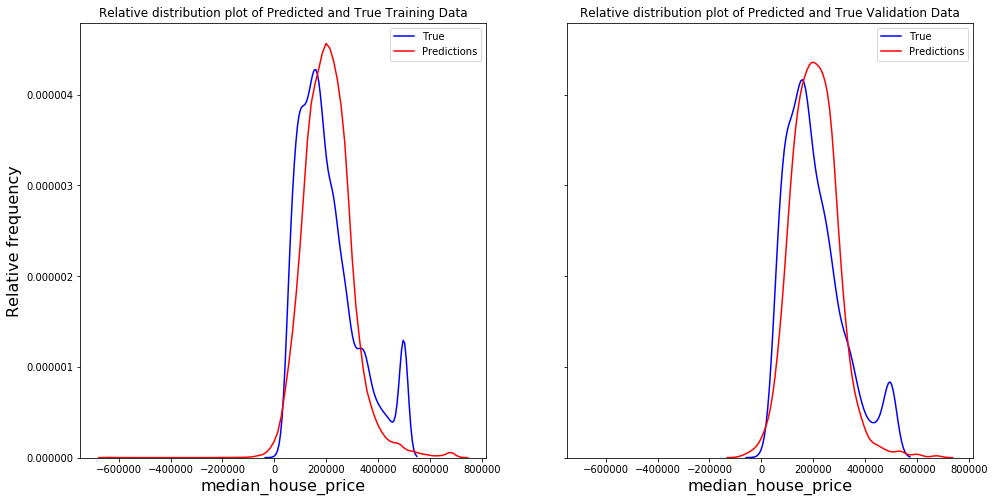

In [36]:
plot_distribution(y_train, lin_reg_simple_allfeatures_predictions_train,
                  y_val, lin_reg_simple_allfeatures_predictions_val)

In [37]:
df_error_metrics.loc['LinReg Model all features'] = lin_reg_simple_allfeatures_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86


Even though the other features did only show a very weak correlation, taking them also into account improves the error metrics. This time with a better performance of the Test-Set (RMSE and MAE of Train-Set are higher)! The reason I guess is the big outlier in the Training-Set.

### Like mentioned above Longitude and Latitude don't have a meaningful scale, so what happens if I leave them out?

In [38]:
features_numerical = ['housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']
df_housing_raw_temp = df_housing_raw.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp[features_numerical],
                                                    df_housing_raw_temp['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_nolatlon = LinearRegression()
lin_reg_simple_nolatlon.fit(X_train, y_train)
lin_reg_simple_nolatlon_predictions_train = lin_reg_simple_nolatlon.predict(X_train)
lin_reg_simple_nolatlon_predictions_val = lin_reg_simple_nolatlon.predict(X_val)

In [39]:
lin_reg_simple_nolatlon_metrics = calc_error_metrics(lin_reg_simple_nolatlon, X_train,
                                                     y_train, y_val,
                                                     lin_reg_simple_nolatlon_predictions_train,
                                                     lin_reg_simple_nolatlon_predictions_val)

R-Squared Training Set:   0.571
R-Squared Validation Set: 0.563
RMSE Training Set:   75954.0
RMSE Validation Set: 74292.3
MAE Training Set:   55864.8
MAE Validation Set: 54838.4

k-fold CROSS Validation:
Scores:  [75959.45499244 74135.1505414  77047.57172099 77842.76814495
 75197.77383102]
Mean Score:  76036.54384616004
Standard dev.:  1312.204093140185


In [40]:
df_error_metrics.loc['LinReg Model no Lat/Lon'] = lin_reg_simple_nolatlon_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20


Leaving out the features "longitude" and "latitude" leads to poorer error metrics.

<br>

# Feature Engineering

### 1.) Create new features by combining existing features

Each row contains data not about a single house, but about many houses (From the data description (see link further up): The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).) <br>
That's why there are values like for example "total_bedrooms=129". I think, it is a good idea (not my idea, but I saw that on a GCP course) to relate some features to the number of households.

In [41]:
df_housing_raw_temp1 = df_housing_raw.copy()
df_housing_raw_temp1 = df_housing_raw_temp1.dropna()
df_housing_raw_temp1 = df_housing_raw_temp1.reset_index(drop=True)
df_housing_raw_temp1 = df_housing_raw_temp1.drop('geometry', axis=1)
df_housing_raw_temp1['rooms_per_household'] = df_housing_raw_temp1['total_rooms'] / df_housing_raw_temp1['households']
df_housing_raw_temp1['bedrooms_per_household'] = df_housing_raw_temp1['total_bedrooms'] / df_housing_raw_temp1['households']
df_housing_raw_temp1['bedrooms_per_room'] = df_housing_raw_temp1['total_bedrooms'] / df_housing_raw_temp1['total_rooms']
df_housing_raw_temp1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,bedrooms_per_room
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,6.98,1.02,0.15
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,6.24,0.97,0.16
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY,8.29,1.07,0.13
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY,5.82,1.07,0.18
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY,6.28,1.08,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20428,-121.09,39.48,25.00,1665.00,374.00,845.00,330.00,1.56,78100.00,INLAND,5.05,1.13,0.22
20429,-121.21,39.49,18.00,697.00,150.00,356.00,114.00,2.56,77100.00,INLAND,6.11,1.32,0.22
20430,-121.22,39.43,17.00,2254.00,485.00,1007.00,433.00,1.70,92300.00,INLAND,5.21,1.12,0.22
20431,-121.32,39.43,18.00,1860.00,409.00,741.00,349.00,1.87,84700.00,INLAND,5.33,1.17,0.22


In [42]:
corr_matrix = df_housing_raw_temp1.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value        1.00
median_income             0.69
rooms_per_household       0.15
total_rooms               0.13
housing_median_age        0.11
households                0.06
total_bedrooms            0.05
population               -0.03
longitude                -0.05
bedrooms_per_household   -0.05
latitude                 -0.14
bedrooms_per_room        -0.26
Name: median_house_value, dtype: float64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp1[df_housing_raw_temp1.columns.difference(['median_house_value', 'ocean_proximity', 'geometry'])],
                                                    df_housing_raw_temp1['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_extfeatures = LinearRegression()
lin_reg_simple_extfeatures.fit(X_train, y_train)
lin_reg_simple_extfeatures_predictions_train = lin_reg_simple_extfeatures.predict(X_train)
lin_reg_simple_extfeatures_predictions_val = lin_reg_simple_extfeatures.predict(X_val)

In [44]:
lin_reg_simple_extfeatures_metrics = calc_error_metrics(lin_reg_simple_extfeatures, X_train,
                                                        y_train, y_val,
                                                        lin_reg_simple_extfeatures_predictions_train,
                                                        lin_reg_simple_extfeatures_predictions_val)

R-Squared Training Set:   0.649
R-Squared Validation Set: 0.649
RMSE Training Set:   68665.5
RMSE Validation Set: 66519.3
MAE Training Set:   49789.9
MAE Validation Set: 48387.5

k-fold CROSS Validation:
Scores:  [69353.78716221 67625.80712203 69942.68708541 69423.39725928
 68133.05857381]
Mean Score:  68895.74744054582
Standard dev.:  869.3376855825999


In [45]:
df_error_metrics.loc['LinReg Model extended features'] = lin_reg_simple_extfeatures_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34


The new features lead to a slight improvement compared to the metrics of the model "LinReg Model all features".

### 2.) Create features from the Categorical Columns (Convert Categorical to Numerical Values)
**Categories of the feature "ocean_proximity"**

In [46]:
cat_encoder = OneHotEncoder()
cat_1hot = cat_encoder.fit_transform(df_housing_raw_temp1[['ocean_proximity']]).toarray()

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

These converted values need to go back into the dataframe and the feature "ocean_proximity" needs to be deleted.

In [48]:
df_cat_1hot = pd.DataFrame(cat_1hot, columns=cat_encoder.categories_[0], dtype='int8')
df_housing_raw_temp2 = pd.concat([df_housing_raw_temp1, df_cat_1hot], axis=1)
df_housing_raw_temp2 = df_housing_raw_temp2.drop('ocean_proximity', axis=1)

How do the new features correlate?

In [49]:
corr_matrix = df_housing_raw_temp2.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value        1.00
median_income             0.69
<1H OCEAN                 0.26
NEAR BAY                  0.16
rooms_per_household       0.15
NEAR OCEAN                0.14
total_rooms               0.13
housing_median_age        0.11
households                0.06
total_bedrooms            0.05
ISLAND                    0.02
population               -0.03
longitude                -0.05
bedrooms_per_household   -0.05
latitude                 -0.14
bedrooms_per_room        -0.26
INLAND                   -0.48
Name: median_house_value, dtype: float64

From the new feature "ocean_proximity" the category "INLAND" gives a relatively high correlation.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp2[df_housing_raw_temp2.columns.difference(['median_house_value', 'geometry'])],
                                                    df_housing_raw_temp2['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_ocean = LinearRegression()
lin_reg_simple_ocean.fit(X_train, y_train)
lin_reg_simple_ocean_predictions_train = lin_reg_simple_ocean.predict(X_train)
lin_reg_simple_ocean_predictions_val = lin_reg_simple_ocean.predict(X_val)

In [51]:
lin_reg_simple_ocean_metrics = calc_error_metrics(lin_reg_simple_ocean, X_train,
                                                  y_train, y_val,
                                                  lin_reg_simple_ocean_predictions_train,
                                                  lin_reg_simple_ocean_predictions_val)

R-Squared Training Set:   0.657
R-Squared Validation Set: 0.660
RMSE Training Set:   67926.9
RMSE Validation Set: 65512.2
MAE Training Set:   48942.2
MAE Validation Set: 47253.6

k-fold CROSS Validation:
Scores:  [68523.64909726 66728.9318002  69315.32763573 68702.27913721
 67553.30995656]
Mean Score:  68164.69952539247
Standard dev.:  914.0030468286167


In [52]:
df_error_metrics.loc['LinReg Model extended ocean prox'] = lin_reg_simple_ocean_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00


Another slight improvement!

**Categories of the feature "County" (NAMELSAD)**

In [53]:
df_housing_raw_temp3 = df_housing_raw_temp2.copy()
df_housing_raw_temp3['County'] = gdf_housing_raw['NAMELSAD']
df_housing_raw_temp3.isna().sum()

longitude                 0
latitude                  0
housing_median_age        0
total_rooms               0
total_bedrooms            0
population                0
households                0
median_income             0
median_house_value        0
rooms_per_household       0
bedrooms_per_household    0
bedrooms_per_room         0
<1H OCEAN                 0
INLAND                    0
ISLAND                    0
NEAR BAY                  0
NEAR OCEAN                0
County                    3
dtype: int64

A County name could not be determined for 3 data points (County= NaN). So they will be deleted.

In [54]:
df_housing_raw_temp3[df_housing_raw_temp3.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,County
1866,-119.96,38.94,27.00,1492.00,393.00,717.00,254.00,1.89,104200.00,5.87,1.55,0.26,0,1,0,0,0,NaN
12447,-121.45,38.54,48.00,3421.00,734.00,1441.00,727.00,1.95,86600.00,4.71,1.01,0.21,0,1,0,0,0,NaN
14762,-117.07,32.60,13.00,1607.00,435.00,983.00,400.00,2.29,106300.00,4.02,1.09,0.27,0,0,0,0,1,NaN


In [55]:
df_housing_raw_temp3 = df_housing_raw_temp3.dropna()
df_housing_raw_temp3 = df_housing_raw_temp3.reset_index(drop=True)

In [56]:
cat_1hot = cat_encoder.fit_transform(df_housing_raw_temp3[['County']]).toarray()
cat_encoder.categories_

[array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
        'Calaveras County', 'Colusa County', 'Contra Costa County',
        'Del Norte County', 'El Dorado County', 'Fresno County',
        'Glenn County', 'Humboldt County', 'Imperial County',
        'Inyo County', 'Kern County', 'Kings County', 'Lake County',
        'Lassen County', 'Los Angeles County', 'Madera County',
        'Marin County', 'Mariposa County', 'Mendocino County',
        'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
        'Napa County', 'Nevada County', 'Orange County', 'Placer County',
        'Plumas County', 'Riverside County', 'Sacramento County',
        'San Benito County', 'San Bernardino County', 'San Diego County',
        'San Francisco County', 'San Joaquin County',
        'San Luis Obispo County', 'San Mateo County',
        'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
        'Shasta County', 'Sierra County', 'Siskiyou County',


In [57]:
df_cat_1hot = pd.DataFrame(cat_1hot, columns=cat_encoder.categories_[0], dtype='int8')
df_housing_raw_temp3 = pd.concat([df_housing_raw_temp3, df_cat_1hot], axis=1)
df_housing_raw_temp3 = df_housing_raw_temp3.drop('County', axis=1)

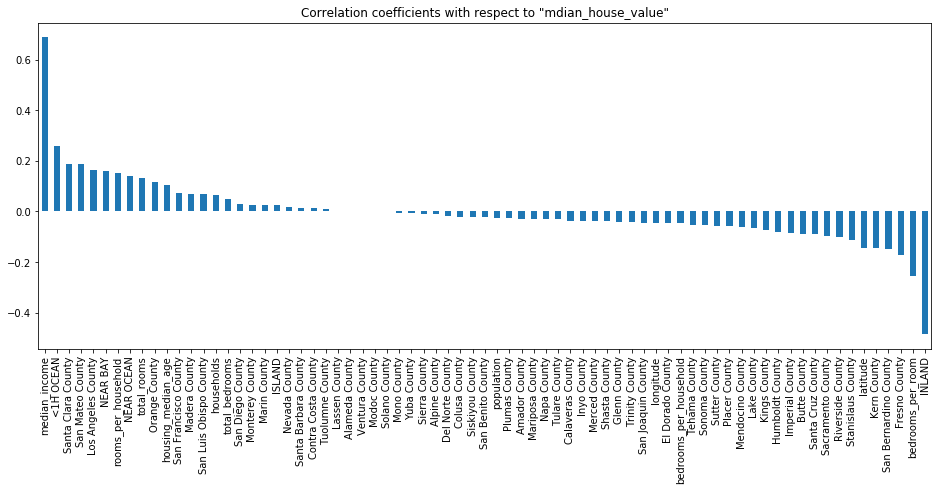

In [58]:
corr_matrix = df_housing_raw_temp3.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16, 6), 
                                                                        title='Correlation coefficients with respect to \"mdian_house_value\"');

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp3[df_housing_raw_temp3.columns.difference(['median_house_value'])],
                                                    df_housing_raw_temp3['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_counties = LinearRegression()
lin_reg_simple_counties.fit(X_train, y_train)
lin_reg_simple_counties_predictions_train = lin_reg_simple_counties.predict(X_train)
lin_reg_simple_counties_predictions_val = lin_reg_simple_counties.predict(X_val)

In [60]:
lin_reg_simple_counties_metrics = calc_error_metrics(lin_reg_simple_counties, X_train,
                                                     y_train, y_val,
                                                     lin_reg_simple_counties_predictions_train,
                                                     lin_reg_simple_counties_predictions_val)

R-Squared Training Set:   0.692
R-Squared Validation Set: 0.688
RMSE Training Set:   64233.8
RMSE Validation Set: 63603.2
MAE Training Set:   45692.4
MAE Validation Set: 44945.2

k-fold CROSS Validation:
Scores:  [63101.73392852 65832.16955567 63971.58664732 66288.88237547
 64523.57615476]
Mean Score:  64743.58973234837
Standard dev.:  1175.841877365199


In [61]:
df_error_metrics.loc['LinReg Model extended counties'] = lin_reg_simple_counties_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84


Another slight improvement!

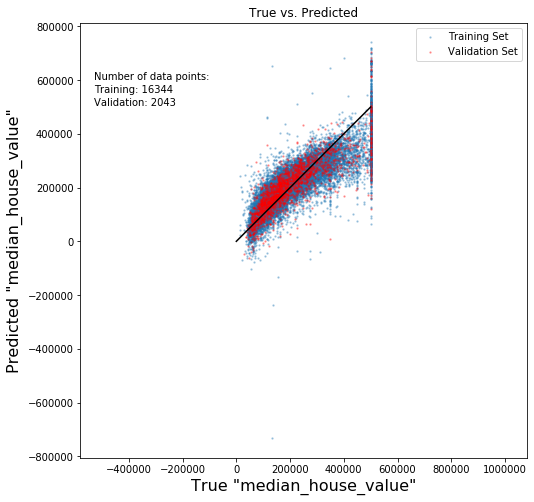

In [62]:
scatter_true_vs_predicted(y_train, lin_reg_simple_counties_predictions_train,
                          y_val, lin_reg_simple_counties_predictions_val)

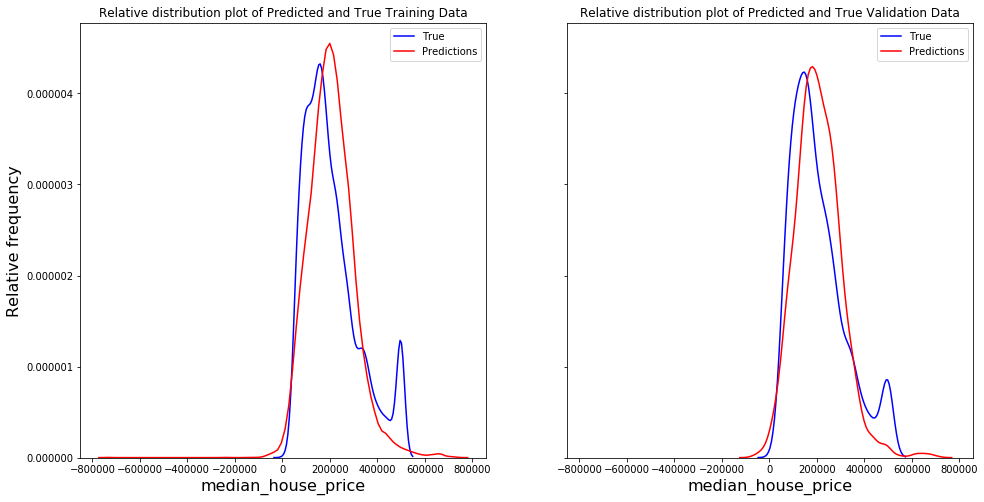

In [63]:
plot_distribution(y_train, lin_reg_simple_counties_predictions_train,
                  y_val, lin_reg_simple_counties_predictions_val)

After having used the columns "Longitude" and "Latitude" to determine which "County" the datapoints belong to, isn't it time to remove the columns "Longitude" and "Latitude"?

In [64]:
df_housing_raw_temp3_1 = df_housing_raw_temp3.drop(['longitude', 'latitude'], axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp3_1[df_housing_raw_temp3_1.columns.difference(['median_house_value'])],
                                                    df_housing_raw_temp3_1['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_counties_nolonlat = LinearRegression()
lin_reg_simple_counties_nolonlat.fit(X_train, y_train)
lin_reg_simple_counties_nolonlat_predictions_train = lin_reg_simple_counties_nolonlat.predict(X_train)
lin_reg_simple_counties_nolonlat_predictions_val = lin_reg_simple_counties_nolonlat.predict(X_val)

In [66]:
lin_reg_simple_counties_nolonlat_metrics = calc_error_metrics(lin_reg_simple_counties_nolonlat, X_train,
                                                              y_train, y_val,
                                                              lin_reg_simple_counties_nolonlat_predictions_train,
                                                              lin_reg_simple_counties_nolonlat_predictions_val)

R-Squared Training Set:   0.680
R-Squared Validation Set: 0.677
RMSE Training Set:   65549.9
RMSE Validation Set: 64679.8
MAE Training Set:   46628.7
MAE Validation Set: 45511.4

k-fold CROSS Validation:
Scores:  [64403.82541045 67441.53303068 64961.97352068 67254.90633768
 66109.10535826]
Mean Score:  66034.2687315487
Standard dev.:  1206.9889756235184


In [67]:
df_error_metrics.loc['LinReg Model extended counties no Lat/Lon'] = lin_reg_simple_counties_nolonlat_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99


=> As can be seen from error metrics, the Lat/Lon columns should not be discarded from the training data

<br>

# What if I had used Stratified Sampling instead of Random Sampling?
Stratified sampling is important to make sure that both the training and the validation set (and test set) represent a similar distribution of values. I split the column "median_house_value" in several categories:

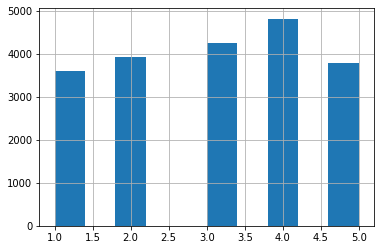

In [68]:
df_housing_raw_temp4 = df_housing_raw_temp3.copy()
df_housing_raw_temp4['median_house_value_cat'] = pd.cut(df_housing_raw_temp4['median_house_value'], 
                                                   bins=[0., 100000, 150000, 200000, 300000, np.inf], 
                                                   labels=[1, 2, 3, 4, 5])
df_housing_raw_temp4['median_house_value_cat'].hist();

In [69]:
# 1st split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
for train_index, test_index in split.split(df_housing_raw_temp4, df_housing_raw_temp4['median_house_value_cat']):
    strat_train_set = df_housing_raw_temp4.loc[train_index]
    strat_test_set = df_housing_raw_temp4.loc[test_index]
strat_train_set = strat_train_set.reset_index(drop=True)
strat_test_set = strat_test_set.reset_index(drop=True)

# 2nd split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=2)
for val_index, test_index in split.split(strat_test_set, strat_test_set['median_house_value_cat']):
    strat_val_set = strat_test_set.loc[val_index]
    strat_test_set = strat_test_set.loc[test_index]

In [70]:
distribution_overall = df_housing_raw_temp4['median_house_value_cat'].value_counts()/len(df_housing_raw_temp4) * 100
distribution_train_set = strat_train_set['median_house_value_cat'].value_counts()/len(strat_train_set) * 100
distribution_val_set = strat_val_set['median_house_value_cat'].value_counts()/len(strat_val_set) * 100
distribution_test_set = strat_test_set['median_house_value_cat'].value_counts()/len(strat_test_set) * 100

In [71]:
pd.DataFrame({'Overall %': distribution_overall,
              'Training Set %': distribution_train_set,
              'Validation Set %': distribution_val_set,
              'Test Set %': distribution_test_set,
              'Training Set % Deviation': ((distribution_train_set - distribution_overall) / distribution_overall * 100),
              'Validation Set % Deviation': ((distribution_val_set - distribution_overall) / distribution_overall * 100),
              'Test Set % Deviation': ((distribution_test_set - distribution_overall) / distribution_overall * 100),
             }).sort_index()

,Overall %,Training Set %,Validation Set %,Test Set %,Training Set % Deviation,Validation Set % Deviation,Test Set % Deviation
1,17.69,17.69,17.67,17.72,0.00,-0.14,0.14
2,19.25,19.24,19.29,19.24,-0.02,0.20,-0.05
3,20.86,20.86,20.85,20.85,0.01,-0.05,-0.05
4,23.60,23.60,23.59,23.59,0.01,-0.02,-0.02
5,18.60,18.60,18.60,18.60,0.00,0.00,0.00


In [72]:
# Remove the "income_cat" feature so that data is back in its original state
for set_ in (strat_train_set, strat_val_set, strat_test_set):
    set_.drop('median_house_value_cat', axis=1, inplace=True)

In [73]:
X_train, y_train = strat_train_set.drop('median_house_value', axis=1), strat_train_set['median_house_value'].copy()
X_val, y_val = strat_test_set.drop('median_house_value', axis=1), strat_test_set['median_house_value'].copy()

In [74]:
lin_reg_simple_stratified = LinearRegression()
lin_reg_simple_stratified.fit(X_train, y_train)
lin_reg_simple_stratified_predictions_train = lin_reg_simple_stratified.predict(X_train)
lin_reg_simple_stratified_predictions_val = lin_reg_simple_stratified.predict(X_val)

In [75]:
lin_reg_simple_stratified_metrics = calc_error_metrics(lin_reg_simple_stratified, X_train,
                                                       y_train, y_val,
                                                       lin_reg_simple_stratified_predictions_train,
                                                       lin_reg_simple_stratified_predictions_val)

R-Squared Training Set:   0.692
R-Squared Validation Set: 0.667
RMSE Training Set:   63938.8
RMSE Validation Set: 66642.2
MAE Training Set:   45621.5
MAE Validation Set: 45723.4

k-fold CROSS Validation:
Scores:  [62270.49681074 62873.03583391 65444.60864691 66798.68669111
 63879.76279608]
Mean Score:  64253.31815574943
Standard dev.:  1665.795749550408


In [76]:
df_error_metrics.loc['LinReg Model stratified'] = lin_reg_simple_stratified_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The predictions of the model with the stratified training data resulted in no improvement. (split into 4 => no improvement; split into 10 => no improvement)

<br>

# Feature Scaling
Machine learning algorithms don't perform well when the features have very different scales (see page 69). <br>
The categorical values of the feature "ocean_proximity" won't be scaled.

In [77]:
df_housing_raw_temp5 = df_housing_raw_temp3.copy()

In [78]:
standard_scaler = StandardScaler()
df_housing_raw_temp5.iloc[:, 0:8] = standard_scaler.fit_transform(df_housing_raw_temp5.iloc[:, 0:8])
df_housing_raw_temp5.iloc[:, 9:12] = standard_scaler.fit_transform(df_housing_raw_temp5.iloc[:, 9:12])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_raw_temp5[df_housing_raw_temp5.columns.difference(['median_house_value'])],
                                                    df_housing_raw_temp5['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_simple_scaled = LinearRegression()
lin_reg_simple_scaled.fit(X_train, y_train)
lin_reg_simple_scaled_predictions_train = lin_reg_simple_scaled.predict(X_train)
lin_reg_simple_scaled_predictions_val = lin_reg_simple_scaled.predict(X_val)

In [80]:
lin_reg_simple_scaled_metrics = calc_error_metrics(lin_reg_simple_scaled, X_train,
                                                   y_train, y_val,
                                                   lin_reg_simple_scaled_predictions_train,
                                                   lin_reg_simple_scaled_predictions_val)

R-Squared Training Set:   0.692
R-Squared Validation Set: 0.688
RMSE Training Set:   64242.8
RMSE Validation Set: 63603.3
MAE Training Set:   45655.4
MAE Validation Set: 44929.3

k-fold CROSS Validation:
Scores:  [6.26651277e+13 6.58305156e+04 6.39834322e+04 6.62950542e+04
 6.45266064e+04]
Mean Score:  12533025586036.078
Standard dev.:  25066051041754.348


In [81]:
df_error_metrics.loc['LinReg Model extended standardized'] = lin_reg_simple_scaled_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The model with the standardized data (based on the "LinReg Model extended counties") did not result in better error metrics.

<br>

# Dealing with irregular data

As could be seen in the distribution plots (further up) certain "median_house_value" seem to appear significantly more often than others, for example 500.000. That's why I'm taking a closer look at the "median_house_value":

In [82]:
df_housing_raw_temp6 = df_housing_raw_temp3.copy()

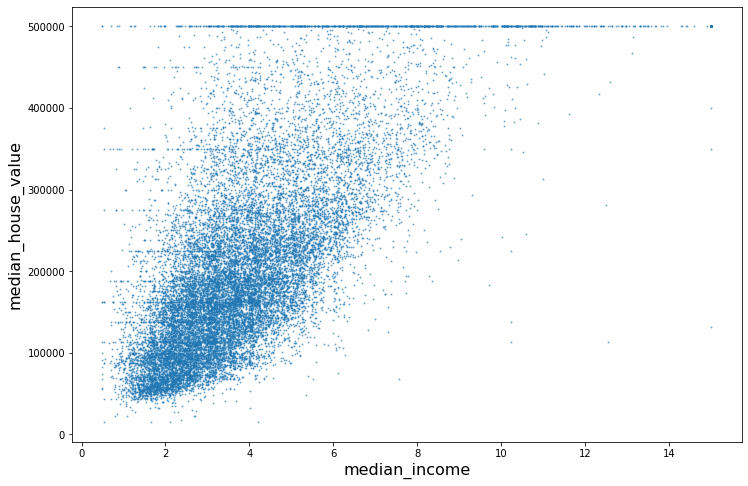

In [83]:
df_housing_raw_temp6.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, s=1.0, figsize=(12, 8));

Clearly some **inconsistencies** at "median_house_value" approx. 500.000. Also at 450.000, 350.000, maybe 280.000, ...
This needs some further investigation:

### First: Find how many times specific "median_house_values" occur

In [84]:
medianhousevalue_occur = df_housing_raw_temp6['median_house_value'].value_counts().sort_values()
df_housevalue_occur = pd.DataFrame({'occurances': medianhousevalue_occur})

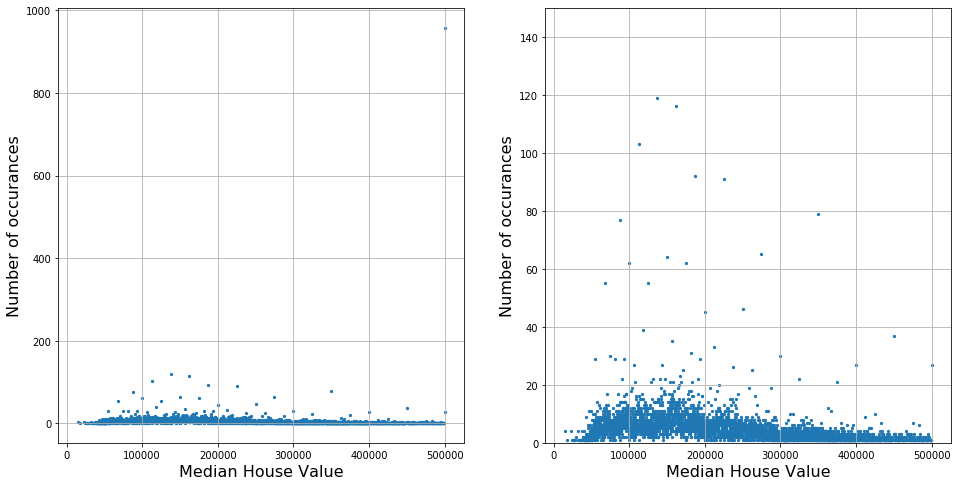

In [85]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.gcf().set_size_inches(16, 8)
ax1.scatter(df_housevalue_occur.index, df_housevalue_occur['occurances'], s=5);
ax1.grid(True)
ax2.scatter(df_housevalue_occur.index, df_housevalue_occur['occurances'], s=5);
ax2.set_ylim(0, 150)
ax2.grid(True)
ax1.set_xlabel('Median House Value')
ax1.set_ylabel('Number of occurances')
ax2.set_xlabel('Median House Value')
ax2.set_ylabel('Number of occurances');

There seems to be certain "Median House Values" that occur significantly more often than others (=> **Outliers**)

### Second: Remove the Outliers (Outliers in this case: occurance > 25):

In [86]:
outliers = df_housing_raw_temp6['median_house_value'].value_counts() > 25
outliers = outliers.index[outliers == True]
df_housing_raw_temp6['bad'] = df_housing_raw_temp5['median_house_value'].isin(outliers)

In [87]:
df_housing_raw_temp6['bad'].value_counts()

False    17856
True      2574
Name: bad, dtype: int64

2574 rows are identified as outliers. (Their "median house value" occurs more often than 25 times.) These rows will be deleted.

In [88]:
df_housing_cleaned = df_housing_raw_temp6[df_housing_raw_temp6['bad'] == False]
df_housing_cleaned = df_housing_cleaned.reset_index(drop=True)

In [89]:
df_housing_cleaned = df_housing_cleaned.drop('bad', axis=1)
df_housing_cleaned.shape

(17856, 74)

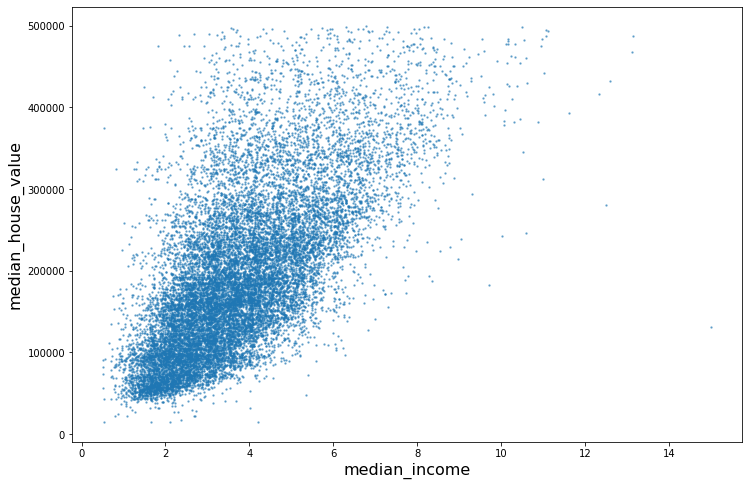

In [90]:
df_housing_cleaned.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, s=2.0, figsize=(12, 8));

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_cleaned[df_housing_cleaned.columns.difference(['median_house_value'])],
                                                    df_housing_cleaned['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

lin_reg_cleaned = LinearRegression()
lin_reg_cleaned.fit(X_train, y_train)
lin_reg_cleaned_predictions_train = lin_reg_cleaned.predict(X_train)
lin_reg_cleaned_predictions_val = lin_reg_cleaned.predict(X_val)

In [92]:
lin_reg_cleaned_metrics = calc_error_metrics(lin_reg_cleaned, X_train,
                                             y_train, y_val,
                                             lin_reg_cleaned_predictions_train,
                                             lin_reg_cleaned_predictions_val)

R-Squared Training Set:   0.698
R-Squared Validation Set: 0.709
RMSE Training Set:   53776.8
RMSE Validation Set: 53427.5
MAE Training Set:   39089.7
MAE Validation Set: 38797.4

k-fold CROSS Validation:
Scores:  [55883.221353   54825.7360235  53343.20289342 55600.34613215
 51856.32845293]
Mean Score:  54301.76697099762
Standard dev.:  1507.3728141778572


In [93]:
df_error_metrics.loc['LinReg Model cleaned'] = lin_reg_cleaned_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The predictions of the model that was trained with the cleaned data have significantly improved!

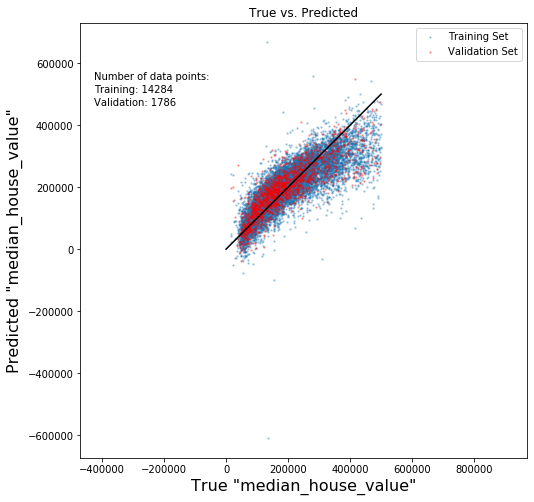

In [94]:
scatter_true_vs_predicted(y_train, lin_reg_cleaned_predictions_train,
                          y_val, lin_reg_cleaned_predictions_val)

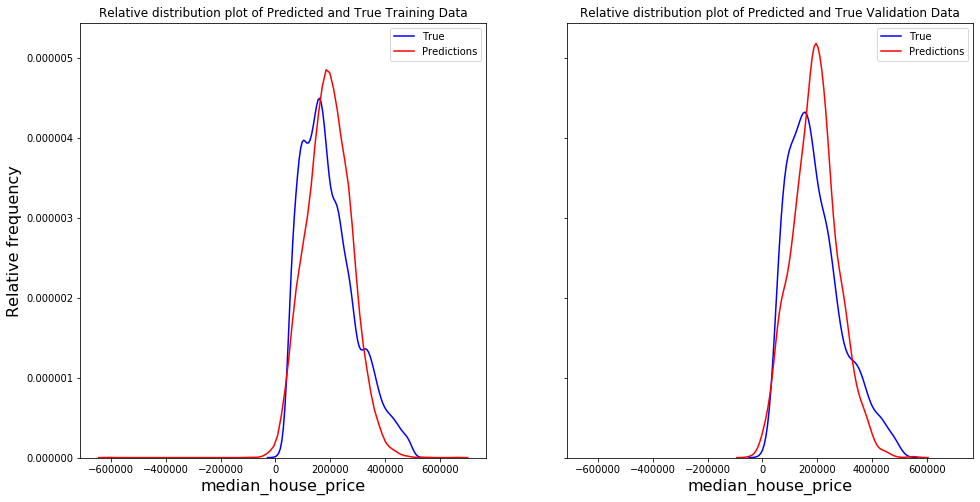

In [95]:
plot_distribution(y_train, lin_reg_cleaned_predictions_train,
                  y_val, lin_reg_cleaned_predictions_val)

<br>

# Using a degree 2 polynomial Linear Regression Model

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_cleaned[df_housing_cleaned.columns.difference(['median_house_value'])],
                                                    df_housing_cleaned['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

In [97]:
%%time
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)
print(X_train_poly.shape)

(14284, 2775)
CPU times: user 25.3 s, sys: 887 ms, total: 26.2 s
Wall time: 13.8 s


In [98]:
lin_reg_poly_predictions_train = lin_reg_poly.predict(X_train_poly)
lin_reg_poly_predictions_val = lin_reg_poly.predict(X_val_poly)

In [99]:
%%time
lin_reg_poly_metrics = calc_error_metrics(lin_reg_poly, X_train_poly,
                                          y_train, y_val,
                                          lin_reg_poly_predictions_train,
                                          lin_reg_poly_predictions_val)

R-Squared Training Set:   0.803
R-Squared Validation Set: -84.891
RMSE Training Set:   43406.1
RMSE Validation Set: 917453.5
MAE Training Set:   30405.7
MAE Validation Set: 68471.0

k-fold CROSS Validation:
Scores:  [ 75606.70921054 251114.54438818  61510.30939045 124770.32815086
 164449.56199474]
Mean Score:  135490.2906269535
Standard dev.:  68383.63254243435
CPU times: user 252 ms, sys: 187 ms, total: 439 ms
Wall time: 1min 6s


The metrics of the training data show improved numbers, but the metrics of the validation data have deteriorated massively. What has happened here? I think, the reason is overfitting of the model. 

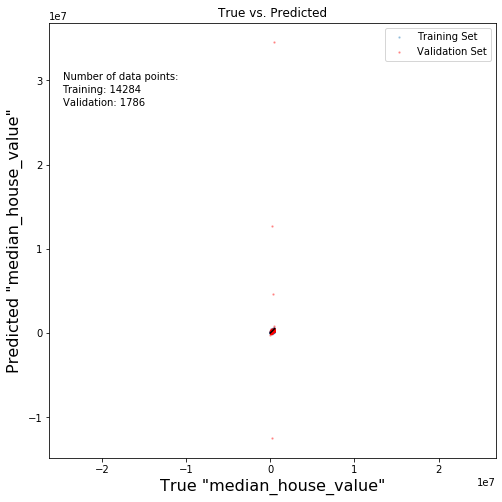

In [100]:
scatter_true_vs_predicted(y_train, lin_reg_poly_predictions_train,
                          y_val, lin_reg_poly_predictions_val)

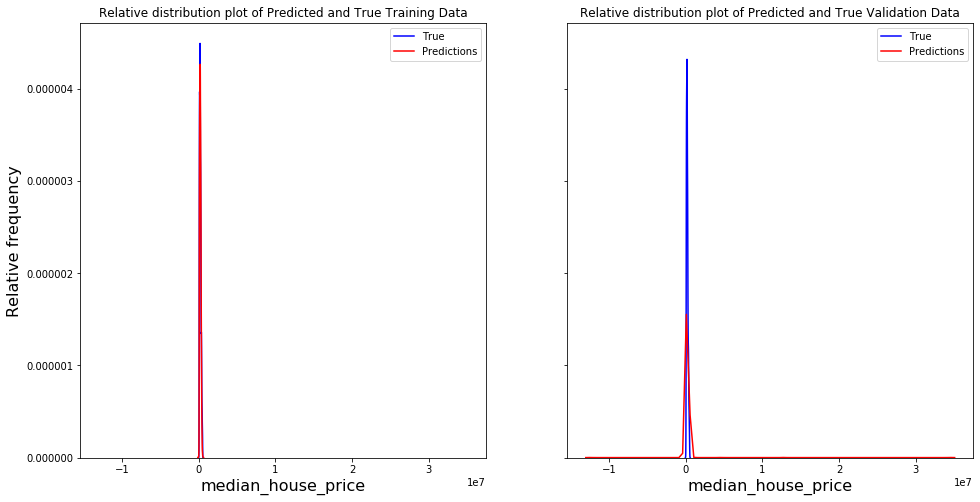

In [101]:
plot_distribution(y_train, lin_reg_poly_predictions_train,
                  y_val, lin_reg_poly_predictions_val)

In [102]:
# Delete the outliers
#to_be_deleted = np.where(lin_reg_poly_predictions_val > 1000000)[0]
#to_be_deleted = np.append(to_be_deleted, np.where(lin_reg_poly_predictions_val < -1000000)[0])

#lin_reg_poly_predictions_val = np.delete(lin_reg_poly_predictions_val, to_be_deleted, axis=0)
#X_val_poly = np.delete(X_val_poly, to_be_deleted, axis=0)
#y_val = y_val.reset_index(drop=True)
#y_val = y_val.drop(index=to_be_deleted)

In [103]:
df_error_metrics.loc['LinReg 2nd degree polynom'] = lin_reg_poly_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


<br>

# Ridge-Regression (L2-Regression)

In [104]:
%%time

param_grid = {'alpha': [0.02, 0.04, 0.06, 0.08, 0.1]}
lin_reg_poly_l2 = Ridge()
lin_reg_poly_l2_grid_search = GridSearchCV(lin_reg_poly_l2, param_grid, cv=5,
                                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
lin_reg_poly_l2_grid_search.fit(X_train_poly, y_train)

CPU times: user 5.18 s, sys: 493 ms, total: 5.68 s
Wall time: 3min 23s


/Users/dirkschulz/anaconda3/envs/portfolio/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.56689e-22): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.02, 0.04, 0.06, 0.08, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [105]:
results = lin_reg_poly_l2_grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

70804.25362903287 {'alpha': 0.02}
70121.38530617848 {'alpha': 0.04}
70014.19056275216 {'alpha': 0.06}
70098.60212293046 {'alpha': 0.08}
70238.73326886426 {'alpha': 0.1}


In [106]:
lin_reg_poly_l2 = Ridge(alpha=0.06)
lin_reg_poly_l2.fit(X_train_poly, y_train)

/Users/dirkschulz/anaconda3/envs/portfolio/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.56689e-22): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=0.06, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [107]:
lin_reg_poly_l2_predictions_train = lin_reg_poly_l2.predict(X_train_poly)
lin_reg_poly_l2_predictions_val = lin_reg_poly_l2.predict(X_val_poly)

In [108]:
%%time
lin_reg_poly_l2_metrics = calc_error_metrics(lin_reg_poly_l2, X_train_poly,
                                             y_train, y_val,
                                             lin_reg_poly_l2_predictions_train,
                                             lin_reg_poly_l2_predictions_val)

R-Squared Training Set:   0.793
R-Squared Validation Set: 0.659
RMSE Training Set:   44529.1
RMSE Validation Set: 57807.4
MAE Training Set:   31296.0
MAE Validation Set: 33640.1

k-fold CROSS Validation:
Scores:  [ 49202.79233448  50817.69492446  52335.82735741 121036.48981383
  46018.5920928 ]
Mean Score:  63882.27930459556
Standard dev.:  28653.817738776408
CPU times: user 279 ms, sys: 157 ms, total: 436 ms
Wall time: 12.6 s


In [109]:
df_error_metrics.loc['LinReg 2nd degree polynom L2'] = lin_reg_poly_l2_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The regularization did improve the error metrics compared to "LinReg 2nd degree polynom". However, the error metrics are worse than those of the "LinReg Model cleaned" except for the MAE. <br>
I tried to run a model with 3rd degree polynom, but the overfitting got worse and the computation time for fitting was approx. 50 min.

<br>

# Training a Random Forest Regressor Model

I use the data from after I removed the outliers in the "median_house_price" column (see several steps further up)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df_housing_cleaned[df_housing_cleaned.columns.difference(['median_house_value'])],
                                                    df_housing_cleaned['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

In [111]:
X_train.shape

(14284, 73)

In [112]:
X_train.memory_usage(deep=True).sum() / 1024 / 1024

2.1523208618164062

Grid search:

In [113]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_jobs=-1)

param_grid = [
    #{'n_estimators': [10, 30, 60, 120],
    # 'max_features': [2, 6, 10, 20]},
    {'bootstrap': [False], 
     'n_estimators': [100, 200, 400],
     'max_features': [20, 30, 40, 50]}
]

grid_search = GridSearchCV(forest_reg, 
                           param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 31.9 s, sys: 438 ms, total: 32.3 s
Wall time: 33min 2s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [114]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

41740.937950184125 {'bootstrap': False, 'max_features': 20, 'n_estimators': 100}
41341.54012226946 {'bootstrap': False, 'max_features': 20, 'n_estimators': 200}
41328.37204492135 {'bootstrap': False, 'max_features': 20, 'n_estimators': 400}
41571.51342956606 {'bootstrap': False, 'max_features': 30, 'n_estimators': 100}
41224.520406329866 {'bootstrap': False, 'max_features': 30, 'n_estimators': 200}
41235.22812429181 {'bootstrap': False, 'max_features': 30, 'n_estimators': 400}
41645.49308865304 {'bootstrap': False, 'max_features': 40, 'n_estimators': 100}
41545.22144828345 {'bootstrap': False, 'max_features': 40, 'n_estimators': 200}
41525.477752441955 {'bootstrap': False, 'max_features': 40, 'n_estimators': 400}
42284.56618697242 {'bootstrap': False, 'max_features': 50, 'n_estimators': 100}
42193.7013362634 {'bootstrap': False, 'max_features': 50, 'n_estimators': 200}
42181.804968473196 {'bootstrap': False, 'max_features': 50, 'n_estimators': 400}


In [115]:
forest_reg = RandomForestRegressor(n_jobs=-1, bootstrap=False, max_features=30, n_estimators=400)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [116]:
forest_reg_predictions_train = forest_reg.predict(X_train)
forest_reg_predictions_val = forest_reg.predict(X_val)

In [117]:
%%time
forest_reg_metrics = calc_error_metrics(forest_reg, X_train,
                                        y_train, y_val,
                                        forest_reg_predictions_train,
                                        forest_reg_predictions_val)

R-Squared Training Set:   1.000
R-Squared Validation Set: 0.831
RMSE Training Set:   0.1
RMSE Validation Set: 40706.3
MAE Training Set:   0.0
MAE Validation Set: 27214.0

k-fold CROSS Validation:
Scores:  [43298.28822061 42039.63193003 40568.48793307 40283.15415976
 40004.5857177 ]
Mean Score:  41238.82959223264
Standard dev.:  1246.4899229662847
CPU times: user 39.4 ms, sys: 12.4 ms, total: 51.8 ms
Wall time: 1min 16s


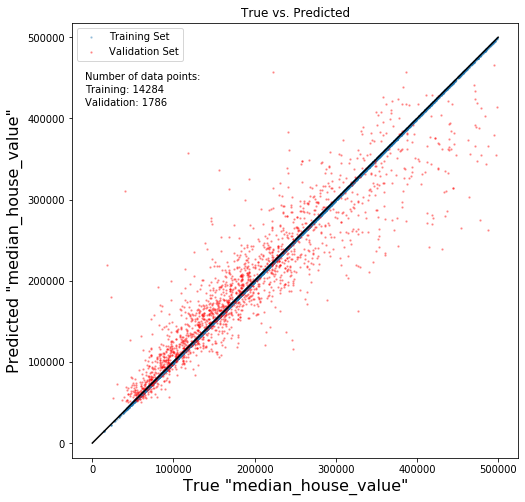

In [118]:
scatter_true_vs_predicted(y_train, forest_reg_predictions_train,
                          y_val, forest_reg_predictions_val)

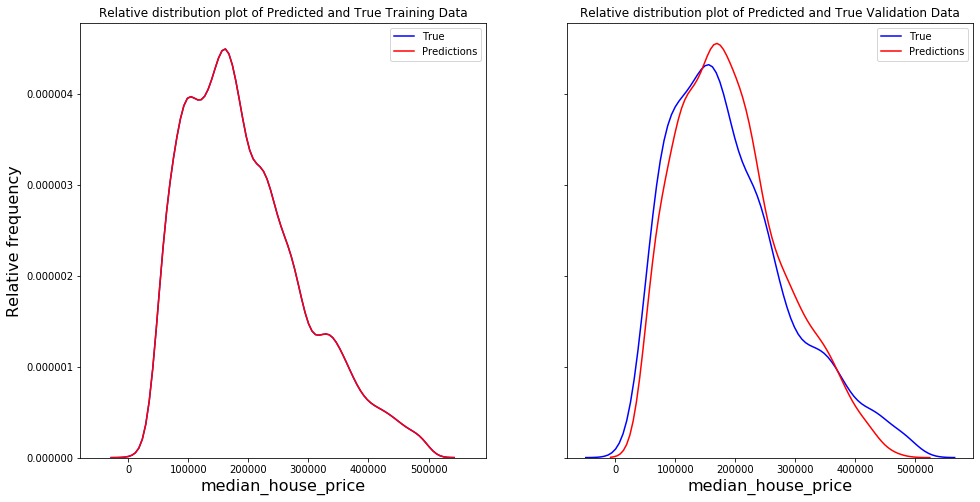

In [119]:
plot_distribution(y_train, forest_reg_predictions_train,
                  y_val, forest_reg_predictions_val)

In [120]:
df_error_metrics.loc['Random Forest'] = forest_reg_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The error metrics of the Random Forest Regressor have strongly improved. However, the model is strongly overfitted (The model fitted with the Training data does not show any error! It's completely memorized). In the next step, I try regularization by changing the hyperparameter "max_depth" and "min_samples_leaf".

### Regularization

In [121]:
%%time
forest_reg = RandomForestRegressor(n_jobs=-1)

param_grid = [
    {'bootstrap': [False], 
     'n_estimators': [400],
     'max_features': [30],
     'max_depth': [15, 20, 30, 40, 50, 60, 80, 100]}
]

grid_search = GridSearchCV(forest_reg, 
                           param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 718 ms, total: 1min 3s
Wall time: 10min 21s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [122]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

41983.684556039676 {'bootstrap': False, 'max_depth': 15, 'max_features': 30, 'n_estimators': 400}
41293.52139059503 {'bootstrap': False, 'max_depth': 20, 'max_features': 30, 'n_estimators': 400}
41168.21663075653 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'n_estimators': 400}
41226.37196780453 {'bootstrap': False, 'max_depth': 40, 'max_features': 30, 'n_estimators': 400}
41261.515974760216 {'bootstrap': False, 'max_depth': 50, 'max_features': 30, 'n_estimators': 400}
41207.80232797168 {'bootstrap': False, 'max_depth': 60, 'max_features': 30, 'n_estimators': 400}
41163.88112703387 {'bootstrap': False, 'max_depth': 80, 'max_features': 30, 'n_estimators': 400}
41223.638096578376 {'bootstrap': False, 'max_depth': 100, 'max_features': 30, 'n_estimators': 400}


In [123]:
%%time
forest_reg = RandomForestRegressor(n_jobs=-1)

param_grid = [
    {'bootstrap': [False], 
     'n_estimators': [400],
     'max_features': [30],
     'max_depth': [30],
     'min_samples_leaf':[1, 2, 3, 4, 5]}
]

grid_search = GridSearchCV(forest_reg, 
                           param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 1min 2s, sys: 830 ms, total: 1min 3s
Wall time: 5min 55s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [124]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

41181.9937968614 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 1, 'n_estimators': 400}
41217.915364151726 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 2, 'n_estimators': 400}
41469.65410228248 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 3, 'n_estimators': 400}
41760.03128329367 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 4, 'n_estimators': 400}
42109.77272259417 {'bootstrap': False, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 5, 'n_estimators': 400}


In [125]:
forest_reg_depth_samples = RandomForestRegressor(n_jobs=-1, bootstrap=False, max_features=30, n_estimators=400,
                                                 max_depth=30, min_samples_leaf=2)
forest_reg_depth_samples.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [126]:
forest_reg_depth_samples_predictions_train = forest_reg_depth_samples.predict(X_train)
forest_reg_depth_samples_predictions_val = forest_reg_depth_samples.predict(X_val)

In [127]:
%%time
forest_reg_depth_samples_metrics = calc_error_metrics(forest_reg_depth_samples, X_train,
                                                      y_train, y_val,
                                                      forest_reg_depth_samples_predictions_train,
                                                      forest_reg_depth_samples_predictions_val)

R-Squared Training Set:   0.993
R-Squared Validation Set: 0.830
RMSE Training Set:   7961.1
RMSE Validation Set: 40768.2
MAE Training Set:   4155.6
MAE Validation Set: 27268.4

k-fold CROSS Validation:
Scores:  [43163.27804849 41995.90637477 40447.63494036 40434.30737643
 40202.39572126]
Mean Score:  41248.70449226203
Standard dev.:  1150.966523316571
CPU times: user 39.9 ms, sys: 13.4 ms, total: 53.3 ms
Wall time: 59.3 s


In [129]:
df_error_metrics.loc['Random Forest, regularized'] = forest_reg_depth_samples_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80


The regularization did not lead to better error metrics.

### What if I had trained without taking into account the County columns?

In [130]:
columns_county = df_housing_cleaned.columns[df_housing_cleaned.columns.str.contains('ounty')].tolist()

In [131]:
df_no_counties = df_housing_cleaned[df_housing_cleaned.columns.difference(columns_county)]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df_no_counties[df_no_counties.columns.difference(['median_house_value'])],
                                                    df_no_counties['median_house_value'],
                                                    test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2) # 0.2 x 0.5 = 0.1

In [133]:
forest_reg_depth_samples_no_counties = RandomForestRegressor(n_jobs=-1)
forest_reg_depth_samples_no_counties.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [134]:
forest_reg_depth_samples_no_counties_predictions_train = forest_reg_depth_samples_no_counties.predict(X_train)
forest_reg_depth_samples_no_counties_predictions_val = forest_reg_depth_samples_no_counties.predict(X_val)

In [135]:
%%time
forest_reg_depth_samples_no_counties_metrics = calc_error_metrics(forest_reg_depth_samples_no_counties, X_train,
                                                                  y_train, y_val,
                                                                  forest_reg_depth_samples_no_counties_predictions_train,
                                                                  forest_reg_depth_samples_no_counties_predictions_val)

R-Squared Training Set:   0.973
R-Squared Validation Set: 0.815
RMSE Training Set:   16084.8
RMSE Validation Set: 42565.6
MAE Training Set:   10932.1
MAE Validation Set: 28756.8

k-fold CROSS Validation:
Scores:  [45656.88840989 44926.95450867 42563.58187994 43060.96159516
 41977.40543859]
Mean Score:  43637.15836645088
Standard dev.:  1412.9566525586743
CPU times: user 38.4 ms, sys: 12.7 ms, total: 51.2 ms
Wall time: 17.9 s


In [136]:
df_error_metrics.loc['Random Forest, no counties'] = forest_reg_depth_samples_no_counties_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,116074.31,91149.64,nan,nan
Median,-0.06,119615.58,88630.35,nan,nan
LinReg Model 1 feature,0.48,84707.21,63412.96,83443.27,729.29
LinReg Model all features,0.64,67762.72,49568.02,69781.54,1066.86
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.54,1312.20
LinReg Model extended features,0.65,66519.27,48387.50,68895.75,869.34
LinReg Model extended ocean prox,0.66,65512.22,47253.65,68164.70,914.00
LinReg Model extended counties,0.69,63603.20,44945.24,64743.59,1175.84
LinReg Model extended counties no Lat/Lon,0.68,64679.85,45511.42,66034.27,1206.99
LinReg Model stratified,0.67,66642.17,45723.42,64253.32,1665.80
